In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import h5py
from collections import Counter
from sklearn.manifold import TSNE
import random
from sklearn.metrics import pairwise_distances
import tqdm
from scipy.spatial import distance
from scipy.interpolate import interp1d
from sklearn import metrics
import pandas as pd
import sys

In [2]:
PATH_TO_OUTPUT = "/aloy/home/acomajuncosa/Protocols/rebutal_analyses/information_loss/"
PATH_TO_CC = "/aloy/web_checker/package_cc/2021_07/full/"
spaces = [i + j for i in "ABCDE" for j in "12345"]
signatures = ['sign0', 'sign1', 'sign2', 'sign3']
elements = [[i,j] for i in spaces for j in signatures]

# Create directory
PATH_TO_PVALUES = os.path.join(PATH_TO_OUTPUT, 'pvalues')
os.makedirs(PATH_TO_PVALUES, exist_ok=True)

In [3]:
len(elements)

100

In [38]:
import os
import sys
from chemicalchecker.util.hpc import HPC
# cc_config.json
cluster_config = {"system" : "sge", "host": "pac-one-head", "queue": "all.q", "username": "acomajuncosa"}

scratch_path = "/aloy/scratch/acomajuncosa/Protocols/rebutal_analyses/information_loss_pvalues"
script_path = "/aloy/home/acomajuncosa/Protocols/rebutal_analyses/information_loss/pvalues.py"

ncpus = 16
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'cc_pval'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/2023_05.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

print('Launched!')

Launched!


In [6]:
# No errors
### check errors
path = '/aloy/scratch/acomajuncosa/Protocols/rebutal_analyses/information_loss_pvalues/'
for file in sorted(os.listdir(path)):
    if ".o" in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() or "warning" in l.lower():
                    print(file)
                    break

In [261]:
### CALCULATE RECAPITULATION ###

In [271]:
elements = [i + j for i in "ABCDE" for j in "12345"]

In [272]:
import os
import sys
from chemicalchecker.util.hpc import HPC
# cc_config.json
cluster_config = {"system" : "sge", "host": "pac-one-head", "queue": "all.q", "username": "acomajuncosa"}

scratch_path = "/aloy/scratch/acomajuncosa/Protocols/rebutal_analyses/information_loss"
script_path = "/aloy/home/acomajuncosa/Protocols/rebutal_analyses/information_loss/recapitulation.py"

ncpus = 16
cluster = HPC(**cluster_config)
njobs = len(elements)

cluster_params = {}
cluster_params['job_name'] = 'cc_recap'
cluster_params["jobdir"] = scratch_path
cluster_params["memory"] = ncpus
cluster_params['cpu'] = ncpus
cluster_params["wait"] = False
cluster_params["elements"] = elements
cluster_params["num_jobs"] = len(elements)


singularity_image = "/aloy/home/acomajuncosa/images/2023_05.simg"
command = "singularity exec {} python {} <TASK_ID> <FILE>".format(
singularity_image,
script_path)

cluster.submitMultiJob(command, **cluster_params)

print('Launched!')

Launched!


In [265]:
# No errors
### check errors
path = '/aloy/scratch/acomajuncosa/Protocols/rebutal_analyses/information_loss'
for file in sorted(os.listdir(path)):
    if ".o" in file:
        with open(os.path.join(path, file), "r") as f:
            for l in f:
                if "error" in l.lower() or "warning" in l.lower():
                    print(file)
                    break

In [266]:
#### READ AND PLOT RESULTS ###
%matplotlib inline

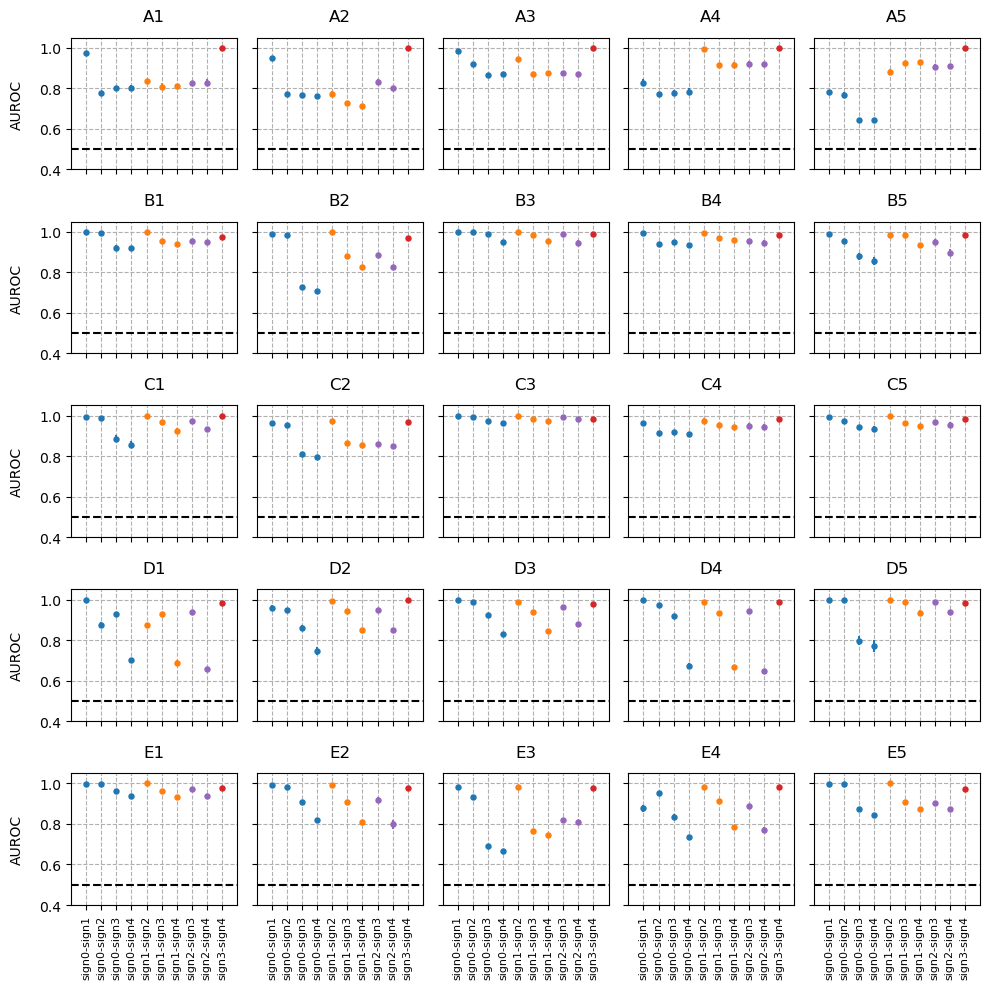

In [7]:
PATH_TO_OUTPUT = "/aloy/home/acomajuncosa/Protocols/rebutal_analyses/information_loss/"
PATH_TO_PVALUES = os.path.join(PATH_TO_OUTPUT, 'pvalues')
PATH_TO_AUROCS = os.path.join(PATH_TO_OUTPUT, 'aurocs')
spaces = [i + j for i in "ABCDE" for j in "12345"]
letter_to_ind = {i: int(j)-1 for i,j in zip("ABCDE", "12345")}
spaces_to_ind = {i: [letter_to_ind[i[0]], int(i[1])-1] for i in spaces}

combinations = ["sign0-sign1", "sign0-sign2", "sign0-sign3", "sign0-sign4", "sign1-sign2", 
                "sign1-sign3", "sign1-sign4", "sign2-sign3", "sign2-sign4", "sign3-sign4"]
sign_to_color = {'sign0': 'tab:blue', 'sign1': 'tab:orange', 'sign2': 'tab:purple', 'sign3': 'tab:red'}

# Plot the figure
fig, ax = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)

for space in spaces:

    # Get c1;c2
    c1, c2 = spaces_to_ind[space]

    # Adjust limits
    ax[c1][c2].set_ylim([0.4, 1.05])
    ax[c1][c2].plot([-1, len(combinations)], [0.5, 0.5], color='k', linestyle='--')
    ax[c1][c2].grid(linestyle='--')
    ax[c1][c2].set_title(space, pad=12)

    # Load data
    path_to_file = os.path.join(PATH_TO_AUROCS, space + ".tsv")
    if os.path.exists(path_to_file) == True:
        data = pd.read_csv(path_to_file, sep='\t')

        # Plot results
        for c, combi in enumerate(combinations):
            aurocs = data[data["Combination"] == combi]['AUROC'].tolist()
            ax[c1][c2].scatter([c], np.mean(aurocs), color=sign_to_color[combi.split("-")[0]], s=13, zorder=2)
            ax[c1][c2].plot([c, c], [np.min(aurocs), np.max(aurocs)], c=sign_to_color[combi.split("-")[0]])
    
    # Y axis
    if space[1] == "1":
        ax[c1][c2].set_ylabel("AUROC", labelpad=11)

    # X axis
    if c1 == 4:
        ax[c1][c2].set_xticks([i for i in range(len(combinations))])
        ax[c1][c2].set_xticklabels(combinations, rotation=90, size=8)
        ax[c1][c2].set_xlim([-1, len(combinations)])



plt.tight_layout()
plt.savefig(os.path.join(PATH_TO_OUTPUT, 'cc_recap.png'), dpi=300)
plt.show()